In [ ]:
!apt update && apt-get install -y libnetcdf-dev libgd-dev
!mkdir -p glmpy
!git clone --depth 1 --filter=blob:none --sparse https://github.com/AquaticEcoDynamics/efi-workshop
!cd efi-workshop && git sparse-checkout set glmpy case_studies && cp -r glmpy ../ && cp -r case_studies ../ && cd .. && rm -rf efi-workshop
!curl https://raw.githubusercontent.com/AquaticEcoDynamics/efi-workshop/refs/heads/main/requirements.txt --output requirements.txt
!pip install -r requirements.txt
!curl https://raw.githubusercontent.com/AquaticEcoDynamics/efi-workshop/refs/heads/main/bin/glm_3.3.3_linux_x86_64 --output glm
!chmod +x glm
!pip install -e glmpy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from glmpy import plots
from glmpy.nml import nml, glm_nml, aed_nml
from glmpy.example_sims import SparklingSim

### Running `SparklingSim`

glm-py's `GLMSim` objects represent a GLM simulation. `GLMSim` objects are responsible for storing all the model data (parameters and boundary condition data) and providing methods needed to run and modify the simulation. The `example_sims` module provides configured `GLMSim` objects that can be run immediately. Initialise an instance of the `SparklingSim` class to get started:  

In [10]:
sparkling = SparklingSim(sim_name="sparkling")

Running the simulation is as simple as calling the `run()` method:

In [ ]:
sparkling.run(time_sim=True, write_log=True)

### Plotting outputs

glm-py's `plots` module provides a collection of classes for plotting GLM outputs with matplotlib. The `LakePlotter` class provides methods for plotting GLM's `lake.csv` output. Initialise an instance of `LakePlotter` by providing the path to the `lake.csv` output. The outputs of calling `run` are saved in a directory that matches the `sim_name` attribute:

In [ ]:
lake = plots.LakePlotter("sparkling/output/lake.csv")

The `lake_volume()` method is used for creating a line plot of the lake volume (m^3). Call the method by providing a matplotlib `Axes` object to plot on:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5)) # creates a Figure and Axes object
lake.lake_volume(ax=ax)

`water_balance_components()` is used to create a daily line plot for the volume of inflow, outflow, overflow, evaporation, rainfall, local runoff, and snowfall (m^3/day). Parameters for matplotlib's `plot` method can be set for each water balance component by providing a dictionary of keyword arguments:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
out = lake.water_balance_components(
    ax=ax, 
    rain_params={"linestyle": "--"},
    local_runoff_params=None, 
    overflow_vol_params=None,
    snowfall_params=None
)
ax.legend(handles=out)

More advanced plots can be created by combining `LakePlotter`'s various plot methods:

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
date_formatter = mdates.DateFormatter("%m/%y")
out = lake.water_balance(ax=ax[0, 0])
ax[0, 0].xaxis.set_major_formatter(date_formatter)
out = lake.water_balance_components(
    ax=ax[0,1], 
    local_runoff_params=None, 
    overflow_vol_params=None,
    snowfall_params=None
)
ax[0, 1].legend(handles=out, ncols=2, loc=0)
ax[0, 1].xaxis.set_major_formatter(date_formatter)
out = lake.lake_temp(ax[1, 0])
ax[1, 0].legend(handles=out, ncols=2, loc=0)
ax[1, 0].xaxis.set_major_formatter(date_formatter)
out = lake.heat_balance_components(ax[1, 1])
ax[1, 1].legend(handles=out, ncols=2, loc=0)
ax[1, 1].xaxis.set_major_formatter(date_formatter)

The `NCPlotter` class of the `plots` module can be used plot an output variable for all depths and timesteps of the simulation. This class is initialised by providing a path to the `output.nc` NetCDF file:

In [2]:
nc = plots.NCPlotter("sparkling/output/output.nc")

Call `plot_var_profile` by providing an `Axes` object to plot on, the variable name to plot, and a dictionary of keyword arguments to pass to matplotlib's `imshow` method (if needed).

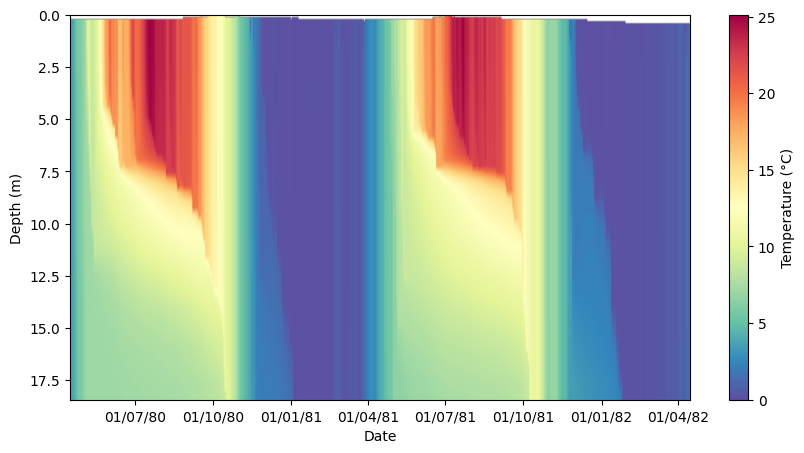

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
out = nc.plot_var_profile(ax=ax, var="temp")
col_bar = fig.colorbar(out)
col_bar.set_label("Temperature (°C)")

`NCPlotter` also provides methods to assist with automating the plotting of variables:

- `get_profile_vars` returns a list of variables that can be plotted with `plot_var_profile`
- `get_long_name` returns the unabbreviated name of a variable
- `get_units` returns the units of a variable

In [4]:
vars = nc.get_profile_vars()
vars

['z',
 'H',
 'V',
 'salt',
 'temp',
 'dens',
 'radn',
 'extc',
 'umean',
 'uorb',
 'taub']

Here, the profile plot of the `salt` and `temp` variables are plotted on separate subplots with `get_long_name` and `get_units` used for the axis labels.

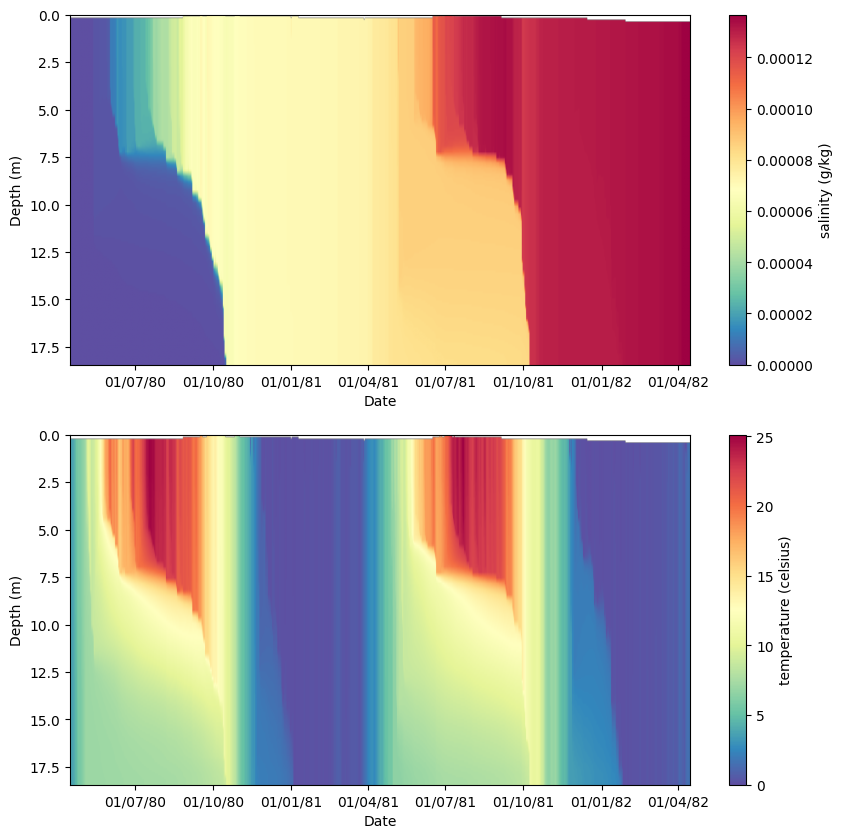

In [6]:
plot_vars = vars[3:5] # returns ['salt', 'temp']
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for idx, var, in enumerate(plot_vars):
    out = nc.plot_var_profile(axs[idx], var)
    long_name = nc.get_long_name(var)
    units = nc.get_units(var)
    col_bar = fig.colorbar(out)
    col_bar.set_label(f"{long_name} ({units})")

### Inspecting the NML

The `nml` attribute of a `GLMSim` object is resposible for storing all the model parameters found in `.nml` files. These parameters are represented as `NMLParam` objects that are stored in a hierarchical structure of `NMLBlock` objects and `NML` objects. Individual parameters can be accessed directly on the `GLMSim` object using the following syntax:

In [ ]:
sparkling.nml["glm"].blocks["glm_setup"].params["min_layer_vol"].value

In [ ]:
sparkling.nml["glm"].blocks["glm_setup"].params["min_layer_vol"].value = 1.0

For a less verbose syntax, parameter values can also be accessed using the `get_param_value()` and `set_param_value()` methods:

In [ ]:
sparkling.set_param_value("glm", "glm_setup", "min_layer_vol", 0.5)

In [ ]:
sparkling.get_param_value("glm", "glm_setup", "min_layer_vol")

Blocks of parameters (`NMLBlock` objects) can also be accessed directly via attributes or using the `get_block()` and `set_block()` methods. The `to_dict()` method returns a dictionary representation of the block's parameters:

In [ ]:
sparkling.nml["glm"].blocks["glm_setup"].to_dict()

In [ ]:
sparkling.get_block("glm", "glm_setup").to_dict()

`NML` objects, that store a collection of `NMLBlock` objects, can be accessed in a similar way:

In [ ]:
sparkling.nml["glm"].to_dict()

In [ ]:
sparkling.get_nml("glm").to_dict()

### Inspecting the boundary conditions

All boundary conditions files needed to run a GLM simulation are stored in the `bcs` attribute. `bcs` is a dictionary where the key is the output file name (without the file extension), and the value is a Pandas `DataFrame` object:

In [ ]:
sparkling.bcs['nldas_driver']

Boundary condition dataframes can be modified using the Pandas API:

In [ ]:
sparkling.bcs['nldas_driver']['ShortWave'] = sparkling.bcs['nldas_driver']['ShortWave'] * 2
sparkling.bcs['nldas_driver']

Reverting to the original:

In [ ]:
sparkling.bcs['nldas_driver']['ShortWave'] = sparkling.bcs['nldas_driver']['ShortWave'] / 2
sparkling.bcs['nldas_driver']

### Adding AED

`SparklingSim` currently lacks the `wq_setup` block needed to configure AED:

In [11]:
print(sparkling.get_block(nml_name="glm", block_name="wq_setup"))

None


You can create a `NMLBlock` object for `wq_setup` using the `WQSetupBlock` class in the `glm_nml` module:

In [12]:
wq_setup = glm_nml.WQSetupBlock(
    wq_lib="aed",
    wq_nml_file='aed/aed.nml',
    ode_method=1,
    split_factor=1,
    bioshade_feedback=True,
    repair_state=True,
)

Next, assign the block to the `GLMNML` object:

In [13]:
sparkling.set_block(nml_name="glm", block=wq_setup)

### Adding depth specific WQ outputs

In addition to using AED, we will also configure GLM to record depth specific measurements for the `temp`, `salt`, and `OXY_oxy` variables. This is achieved using the `OutputBlock`:

In [14]:
output = glm_nml.OutputBlock(
    out_dir="output",
    out_fn="output",
    nsave=24,
    csv_lake_fname="lake",
    csv_point_nlevs=1,
    csv_point_fname="WQ_",
    csv_point_at=[17.0],
    csv_point_nvars=3,
    csv_point_vars=["temp", "salt", "OXY_oxy"]
)
sparkling.set_block(nml_name="glm", block=output)

### Case 1

For the first case study, you will run the simulation with only the `aed_oxygen` module turned on. Rather than setting all the blocks/parameters individually, you will load a JSON file of parameters and use `NMLReader` to construct the desired `AEDNML` object.

In [15]:
nml_file = nml.NMLReader("case_studies/aed_case1.json")
aed_nml_obj = nml_file.to_nml_obj(aed_nml.AEDNML)
print(type(aed_nml_obj))

<class 'glmpy.nml.aed_nml.AEDNML'>


In [16]:
sparkling.set_nml(aed_nml_obj)
sparkling.get_param_value("aed", "aed_models", "models")

['aed_oxygen']

To avoid overwriting the previous Sparkling outputs, change the `sim_name` attribute. This will set the name of simulation output directory and update the `sim_name` parameter in the `glm_setup` block:

In [ ]:
sparkling.sim_name = "case_1"

Next, run the model:

In [ ]:
sparkling.run(time_sim=True, write_log=True)

To create a profile plot for Case 1, change the `glm_nc` attribute of the `NCPlotter` class you initialised earlier:

In [8]:
nc.glm_nc = "case_1/output/output.nc"
nc.get_profile_vars()

['z',
 'H',
 'V',
 'salt',
 'temp',
 'dens',
 'radn',
 'extc',
 'umean',
 'uorb',
 'taub',
 'OXY_oxy',
 'OXY_sat',
 'OXY_oxy_dsfv',
 'OXY_oxy_atmv']

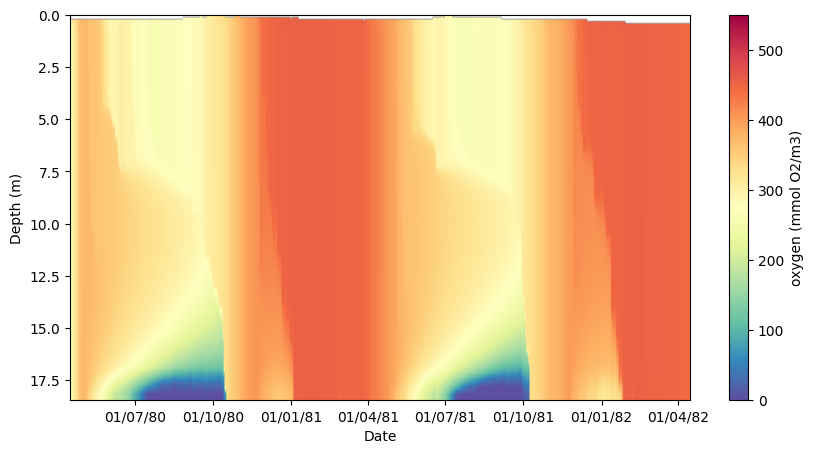

In [9]:
var = "OXY_oxy"
fig, ax = plt.subplots(figsize=(10, 5))
plot_params = {"vmin": 0, "vmax": 550} # set plot_params = {} for default plotting limits
out = nc.plot_var_profile(ax=ax, var=var, param_dict=plot_params)
col_bar = fig.colorbar(out)

var_long_name = nc.get_long_name(var)
var_units = nc.get_units(var)
col_bar.set_label(f"{var_long_name} ({var_units})")

`NCPlotter` also supports plotting a variable for each sediment zones using `plot_var_zone()`. The number of sediment zones are determined by the `n_zones` parameters of the `sediment` block:

In [17]:
sparkling.get_param_value("glm", "sediment", "n_zones")

3

To find the variables that can be plotted with `plot_var_zone()`. Call the `get_zone_vars()` method:

In [18]:
nc.get_zone_vars()

['OXY_oxy_dsf_Z', 'OXY_oxy_atm_Z']

Plot a variable for spexific zone by providing `plot_var_zone` with the `Axes` object, the variable name, the zone number, and any additional keyword arguments that will by passed to matplotlib's `plot()` method:

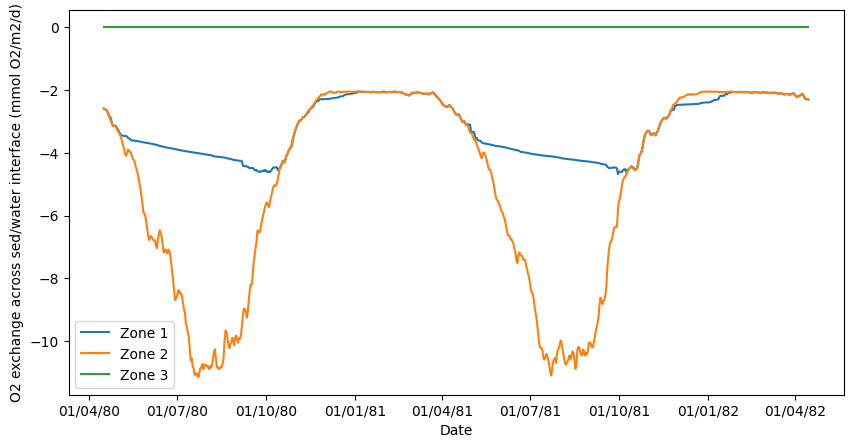

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
nc.plot_var_zone(ax=ax, var="OXY_oxy_dsf_Z", zone=1, param_dict={"label": "Zone 1"})
nc.plot_var_zone(ax, "OXY_oxy_dsf_Z", 2, {"label": "Zone 2"})
nc.plot_var_zone(ax, "OXY_oxy_dsf_Z", 3, {"label": "Zone 3"})
ax.legend()

### Case 2

In [ ]:
nml_file = nml.NMLReader("case_studies/aed_case2.json")
aed_nml_obj = nml_file.to_nml_obj(aed_nml.AEDNML)
sparkling.set_nml(aed_nml_obj)
sparkling.get_param_value("aed", "aed_models", "models")

In [ ]:
sparkling.sim_name = "case_2"

In [ ]:
sparkling.run(time_sim=True, write_log=True)

In [ ]:
nc.glm_nc = "case_2/output/output.nc"
nc.get_vars()

In [ ]:
var = "OXY_oxy"
fig, ax = plt.subplots(figsize=(10, 5))
plot_params = {"vmin": 0, "vmax": 550}
out = nc.plot_var(ax=ax, var=var, param_dict=plot_params)
col_bar = fig.colorbar(out)

var_long_name = nc.get_long_name(var)
var_units = nc.get_units(var)
col_bar.set_label(f"{var_long_name} ({var_units})")

### Case 3

In [ ]:
nml_file = nml.NMLReader("case_studies/aed_case3.json")
aed_nml_obj = nml_file.to_nml_obj(aed_nml.AEDNML)
sparkling.set_nml(aed_nml_obj)
sparkling.aed_dbase = ["case_studies/aed_phyto_pars.csv"]
sparkling.get_param_value("aed", "aed_models", "models")

In [ ]:
sparkling.sim_name = "case_3"

In [ ]:
sparkling.run(time_sim=True, write_log=True)

In [ ]:
nc.glm_nc = "case_3/output/output.nc"
nc.get_vars()

In [ ]:
var = "OXY_oxy"
fig, ax = plt.subplots(figsize=(10, 5))
plot_params = {"vmin": 0, "vmax": 550}
out = nc.plot_var(ax=ax, var=var, param_dict=plot_params)
col_bar = fig.colorbar(out)

var_long_name = nc.get_long_name(var)
var_units = nc.get_units(var)
col_bar.set_label(f"{var_long_name} ({var_units})")

### Case 4

In [ ]:
nml_file = nml.NMLReader("case_studies/aed_case4.json")
aed_nml_obj = nml_file.to_nml_obj(aed_nml.AEDNML)
sparkling.nml["aed"] = aed_nml_obj
sparkling.get_param_value("aed", "aed_models", "models")

In [ ]:
sparkling.sim_name = "case_4"

In [ ]:
sparkling.run(time_sim=True, write_log=True)

In [ ]:
nc.glm_nc = "case_4/output/output.nc"
nc.get_vars()

In [ ]:
var = "OXY_oxy"
fig, ax = plt.subplots(figsize=(10, 5))
plot_params = {"vmin": 0, "vmax": 550}
out = nc.plot_var(ax=ax, var=var, param_dict=plot_params)
col_bar = fig.colorbar(out)

var_long_name = nc.get_long_name(var)
var_units = nc.get_units(var)
col_bar.set_label(f"{var_long_name} ({var_units})")

### Case 5

In [ ]:
nml_file = nml.NMLReader("case_studies/aed_case5.json")
aed_nml_obj = nml_file.to_nml_obj(aed_nml.AEDNML)
sparkling.nml["aed"] = aed_nml_obj
sparkling.get_param_value("aed", "aed_models", "models")

In [ ]:
sparkling.sim_name = "case_5"

In [ ]:
sparkling.run(time_sim=True, write_log=True)

In [ ]:
nc.glm_nc = "case_5/output/output.nc"
nc.get_vars()

In [ ]:
var = "OXY_oxy"
fig, ax = plt.subplots(figsize=(10, 5))
plot_params = {"vmin": 0, "vmax": 550}
out = nc.plot_var(ax=ax, var=var, param_dict=plot_params)
col_bar = fig.colorbar(out)

var_long_name = nc.get_long_name(var)
var_units = nc.get_units(var)
col_bar.set_label(f"{var_long_name} ({var_units})")

### Case 6

In [ ]:
nml_file = nml.NMLReader("case_studies/aed_case6.json")
aed_nml_obj = nml_file.to_nml_obj(aed_nml.AEDNML)
sparkling.set_nml(aed_nml_obj)
sparkling.aed_dbase = [
    "case_studies/aed_phyto_pars.csv", "case_studies/aed_zoop_pars.csv"
]
sparkling.get_param_value("aed", "aed_models", "models")

In [ ]:
sparkling.sim_name = "case_6"

In [ ]:
sparkling.run(time_sim=True, write_log=True)

In [ ]:
nc.glm_nc = "case_6/output/output.nc"
nc.get_vars()

In [ ]:
var = "OXY_oxy"
fig, ax = plt.subplots(figsize=(10, 5))
plot_params = {"vmin": 0, "vmax": 550}
out = nc.plot_var(ax=ax, var=var, param_dict=plot_params)
col_bar = fig.colorbar(out)

var_long_name = nc.get_long_name(var)
var_units = nc.get_units(var)
col_bar.set_label(f"{var_long_name} ({var_units})")

### Depth specific comparison

The `WQPlotter` class is used for plotting the depth specific `WQ_` CSV outputs:

In [ ]:
wq = plots.WQPlotter("case_1/output/WQ_17.csv")
wq.get_vars()

To compare all 6 case studies, iteratively update the `wq_csv` attribute to the output CSV path and call the `plot_var` method. Configure a legend by passing a dictionary containing the `label` keyword argument to matplotlib's `plot` method via `param_dict`.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
wq = plots.WQPlotter()
for i in range(1, 6):
  wq.wq_csv = f"case_{i}/output/WQ_17.csv"
  wq.plot_var(ax=ax, var="OXY_oxy", param_dict={"label": f"case_{i}"})
ax.legend()